# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import sys
!{sys.executable} -m pip install -U rfpimp pandas numpy scikit-learn seaborn
# %pip install -U rfpimp

Requirement already up-to-date: rfpimp in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (1.3.6)
Requirement already up-to-date: pandas in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (1.1.5)
Requirement already up-to-date: numpy in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (1.19.4)
Requirement already up-to-date: scikit-learn in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (0.24.0)
Requirement already up-to-date: seaborn in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (0.11.1)
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
# %%time
from plugins.plugin_utils import *
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from IPython.core.magic import (Magics, magics_class, line_magic, cell_magic)
from IPython import get_ipython
from datetime import datetime
from sklearn.metrics import make_scorer, f1_score, fbeta_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, fbeta_score, accuracy_score
import pickle
from time import time
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=12) 

def none_on_exception(fn):
	@functools.wraps(fn)
	def inner(*args, **kwargs):
		try:
			return fn(*args, **kwargs)
		except Exception:
			return None
	return inner

conn = prepare_connection(sqlite3.connect('starbucks.db', detect_types=sqlite3.PARSE_DECLTYPES))

@magics_class
class SqlMagic(Magics):

    @cell_magic
    def sql(self, line, cell):
        return conn.execute(cell).fetchall()

    @cell_magic
    def to_df(self, line, cell):
        return pd.read_sql(cell, conn)
    
get_ipython().register_magics(SqlMagic)    
sql = lambda x: conn.execute(x).fetchall()
to_df = lambda x: pd.read_sql(x, conn)
conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN

# read in the json files
def load_json_file_to_table(fname):
    print(f'Loading data from {fname}...')
    fname = fname.replace('.json','')
    pd.read_json(f"data/{fname}.json", 
                 orient='records', 
                 lines=True
                ).to_sql(
                        fname,
                        conn,
                        index=False,
                        if_exists='replace')
    
load_json_file_to_table('portfolio.json')
load_json_file_to_table('profile.json')
load_json_file_to_table('transcript.json')

Loading data from portfolio.json...
Loading data from profile.json...
Loading data from transcript.json...


In [42]:
%%time
def clean_transcripts():
    """Splits out offers from the transcript dataset with transcripts excluded."""
    return (to_df(
        """select person,
               event,
               json_extract(value, '$.offer_id') offer_id,
               json_extract(value, '$.reward')   reward,
               time
        from (
                 select person, event, replace(value, 'offer id', 'offer_id') value, time
                 from transcript
                 where event like '%offer%'
             );""")
            .join(pd.get_dummies(offers.event, prefix='event_'), how='outer')
            .drop(columns=['event', 'reward']))

def clean_transcripts():
    """Splits out transcript data from the transcript dataset with offers excluded."""
    return to_df("""select person, 
                               -- event, 
                               json_extract(value, '$.amount') amount, time
                            from transcript
                            where event not like '%offer%';""")


def clean_profile():
    profile = to_df('select * from profile')
    profile.age = profile.age.astype(int)
    
    #CONVERT GENDER TO CATEGORY
#     profile = pd.concat([profile, pd.get_dummies(profile.gender, prefix='gender_')]).drop(columns=['gender'])
    profile.gender = profile.gender.astype('category')
    
    #CLEAN DATE FIELD
    conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN
    profile.became_member_on = profile.became_member_on.apply(conv_date).astype('datetime64')

    #BINNING AGE BRACKETS
    profile = profile[profile.age != 118]
    age_map = {i*10:grp for grp, i in enumerate(range(0,15))}
    profile['age_by_decade'] = profile.age.apply(lambda x: age_map[int(str(x)[:-1] + '0')])
    profile.drop(columns=['age'])
    
    profile.income = profile.income.astype(int)
    return profile

def clean_portfolio():
    """
    Engineers multiple features from the original channel and offer_type variables.
    
    Example adapted from:
    https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
    """
    portfolio = to_df('select * from portfolio')
    portfolio.channels = portfolio.channels.apply(json.loads)
    portfolio.channels = portfolio.channels.apply(lambda x: sorted(x))
    _ = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio[list(_)] = _
    portfolio = portfolio.drop(columns=['channels'])
    portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type, prefix='offer_type_'),
                           how='outer').drop(columns=['offer_type'])
    return portfolio

def merge_datasets(offers, transactions, portfolio, profile):
    """
    Merges all the cleaned datasets together to form one joined
    set of features.
    """
    offers_cols = ['person', 'offer_id', 'time', "event__offer completed", 
                   "event__offer received", "event__offer viewed",]
    profile_cols = ['id','gender','age','became_member_on','income',]
    portfolio_cols = ['id','reward','difficulty','duration','email','mobile','social',
    'web','offer_type__bogo','offer_type__discount','offer_type__informational',]

    return (offers[offers_cols].rename(columns={'person':'offer_person_id'})
         .merge(profile.rename(columns={'id':'profile_person_id'}), 
                left_on='offer_person_id',
                right_on='profile_person_id',
                how='inner')
         .merge(portfolio[portfolio_cols].rename(columns={'id':'portfolio_id'}),
                left_on='offer_id',
                right_on='portfolio_id', 
                how='inner')
         .merge(transactions.groupby(by='person')['amount'].mean().reset_index(),
                left_on='profile_person_id',
                right_on='person',
                how='inner'
         )
    )

def clean_merged_dataset(joined):
    """
    Cleanes the resultant merged dataset joined via the 'merge_datasets' function.
    
    NOTE: This function is separate from the previous functions because exploration 
    and visualization is preformed on the merged dataset prior to cleaning
    """
    joined['days_as_customer'] = joined.became_member_on.apply(lambda x: pd.Timestamp.now() - pd.to_datetime(x)).dt.days
    joined['became_member_dayofweek'] = joined.became_member_on.dt.dayofweek
    joined['became_member_month'] = joined.became_member_on.dt.month
    joined['became_member_year'] =  joined.became_member_on.dt.year
    joined = joined.drop(columns=['became_member_on', 'time', 'reward', 'age'])
    return joined

CPU times: user 46 µs, sys: 95 µs, total: 141 µs
Wall time: 145 µs


In [3]:
%%time
offers, transactions = clean_transcripts()
portfolio = clean_portfolio()
profile = clean_profile()

CPU times: user 1.23 s, sys: 44.6 ms, total: 1.27 s
Wall time: 1.28 s


In [5]:
"""TODO:
- (Optional) - Add exploratory visualizations. Distributions, correlation matrix to check for colinearity, scatterplot etc..
- Change age bracket to bins and use get_dummies
- Remove duplicate ID columns and drop / fix NaNs
- Change reward to binary?? (look to see if Reward only goes with one type of offer)
- Input / Normalize / standarize numeric features
- Join all the datasets"""
print('Offers:\n'); display(offers.sample(5))
print('Transactions:\n'); display(transactions.sample(5))
print('Portfolio:\n'); display(portfolio.sample(5))
print('Profile:\n'); display(profile.sample(5))

Offers:



,person,offer_id,time,event__offer completed,event__offer received,event__offer viewed
38483,83ced1e7b3a84583a9dde0783e2190c1,4d5c57ea9a6940dd891ad53e9dbe8da0,168,0,1,0
30759,1fa18ac894ce457686b3d3264eb192f5,3f207df678b143eea3cee63160fa8bed,168,0,1,0
154735,917c006586784776a1d11ba0e7671158,4d5c57ea9a6940dd891ad53e9dbe8da0,588,0,0,1
18803,eb3ce155c32f4c80a29a3417a1e698d5,2906b810c7d4411798c6938adc9daaa5,18,0,0,1
79970,b2f1cd155b864803ad8334cdf13c4bd2,2298d6c36e964ae4a3e7e9706d1fb8c2,396,0,0,1


Transactions:



,person,amount,time
84109,a6eee494b513443099e657f362abcdec,1.82,468
125724,4a77318aff504e48837d945af45d6727,0.50,648
136938,c35d2009f1a1434fb4f59658f14ad0ec,27.15,702
38957,97412a543c2c4ff9948a92cfd90688f8,19.05,234
29189,bf4a0a21b0b64c869a573f6a4e91de18,2.24,186


Portfolio:



,reward,difficulty,duration,id,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


Profile:



,gender,age,id,became_member_on,income,age_by_decade
14428,M,35,ea9b65b0bef54e4c9dcf73409d9ead12,2016-08-07,57000,3
12792,F,64,a43342085d674672b26ddd5331f47c17,2017-10-30,73000,6
1274,F,56,ab305aaca596410897039012bef166a6,2015-10-10,40000,5
13032,F,66,b86ff24831f54f3cbbcd605f763abbe8,2018-04-29,46000,6
13132,M,37,3835f3a19c534c359faaf72b0861c32a,2016-04-04,74000,3


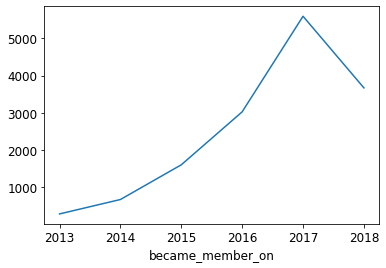

In [6]:
profile.groupby(profile.became_member_on.dt.year).count()['age'].plot()

In [7]:
# for c in list(transcript):
#     print(transcript.isnull().sum())
print('Total rows:', len(profile), len(offers), len(transactions))
sep = '\n'+'*'*60 + '\n'
# print(f'{sep}Transcript % NULLs:{sep}{transcript.isnull().sum()/len(transcript)}')
print(f'{sep}Offers % NULLs:{sep}{offers.isnull().sum()/len(offers)}')
print(f'{sep}Transactions % NULLs:{sep}{transactions.isnull().sum()/len(transactions)}')
print(f'{sep}Profile % NULLs:{sep}{profile.isnull().sum()/len(profile)}')
print(f'{sep}Portfolio % NULLs:{sep}{portfolio.isnull().sum()/len(portfolio)}')

Total rows: 14825 167581 138953

************************************************************
Offers % NULLs:
************************************************************
person                    0.0
offer_id                  0.0
time                      0.0
event__offer completed    0.0
event__offer received     0.0
event__offer viewed       0.0
dtype: float64

************************************************************
Transactions % NULLs:
************************************************************
person    0.0
amount    0.0
time      0.0
dtype: float64

************************************************************
Profile % NULLs:
************************************************************
gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
age_by_decade       0.0
dtype: float64

************************************************************
Portfolio % NULLs:
****************************************************

In [8]:
joined = merge_datasets(offers, transactions, portfolio, profile)

In [9]:
print('Total:', len(joined))
print(f'{sep}Joined % NULLs:{sep}{joined.isnull().sum()/len(joined)}')
'''Dropping since theres less than 20% of rows with missing records'''
joined = joined.dropna()

Total: 146188

************************************************************
Joined % NULLs:
************************************************************
offer_person_id              0.0
offer_id                     0.0
time                         0.0
event__offer completed       0.0
event__offer received        0.0
event__offer viewed          0.0
gender                       0.0
age                          0.0
profile_person_id            0.0
became_member_on             0.0
income                       0.0
age_by_decade                0.0
portfolio_id                 0.0
reward                       0.0
difficulty                   0.0
duration                     0.0
email                        0.0
mobile                       0.0
social                       0.0
web                          0.0
offer_type__bogo             0.0
offer_type__discount         0.0
offer_type__informational    0.0
person                       0.0
amount                       0.0
dtype: float64


In [10]:
print(f'{sep}Correlations:{sep}')
pd.DataFrame([(*sorted([k.capitalize(), c.capitalize()]), v[c])
                     for k,v in joined.corr().items() 
                     for c in list(v.index)
        if not k == c and v[c] > .5],
            columns=['ROW','COL','CORRELATION']
            ).drop_duplicates()


************************************************************
Correlations:
************************************************************



,ROW,COL,CORRELATION
0,Age,Age_by_decade,0.986144
2,Offer_type__bogo,Reward,0.797155
3,Difficulty,Duration,0.766105
4,Difficulty,Offer_type__discount,0.541881
6,Duration,Offer_type__discount,0.731009


In [11]:
%%time
joined = clean_merged_dataset(joined)

CPU times: user 3.43 s, sys: 39.1 ms, total: 3.47 s
Wall time: 3.49 s


In [17]:
joined.describe()

,event__offer completed,event__offer received,event__offer viewed,income,age_by_decade,difficulty,duration,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational,amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
count,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.0,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000,146188.000000
mean,0.221933,0.444770,0.333297,66282.731825,5.021609,7.892454,6.626351,1.0,0.917435,0.659329,0.806592,0.429584,0.418776,0.151640,16.255038,1425.895758,3.030741,6.712247,2016.560190
std,0.415548,0.496942,0.471393,21512.940879,1.749834,5.033671,2.131765,0.0,0.275224,0.473936,0.394972,0.495018,0.493360,0.358673,16.567522,415.807979,2.005154,3.498085,1.186961
min,0.000000,0.000000,0.000000,30000.000000,1.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,882.000000,0.000000,1.000000,2013.000000
25%,0.000000,0.000000,0.000000,50000.000000,4.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.868571,1106.000000,1.000000,4.000000,2016.000000
50%,0.000000,0.000000,0.000000,65000.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15.368750,1288.000000,3.000000,7.000000,2017.000000
75%,0.000000,1.000000,1.000000,81000.000000,6.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,21.994000,1704.000000,5.000000,10.000000,2017.000000
max,1.000000,1.000000,1.000000,120000.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,451.470000,2705.000000,6.000000,12.000000,2018.000000


In [18]:
joined.sample(5)

,offer_person_id,offer_id,event__offer completed,event__offer received,event__offer viewed,gender,profile_person_id,income,age_by_decade,portfolio_id,...,web,offer_type__bogo,offer_type__discount,offer_type__informational,person,amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
45648,bf3069b178fe40d789dd027901bc406b,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,F,bf3069b178fe40d789dd027901bc406b,63000,5,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,1,0,1,0,bf3069b178fe40d789dd027901bc406b,18.790000,1242,0,7,2017
76165,13fec8f3cfae4ca186eab06b75cb3cec,5a8bc65990b245e5a138643cd4eb9837,0,1,0,M,13fec8f3cfae4ca186eab06b75cb3cec,63000,5,5a8bc65990b245e5a138643cd4eb9837,...,0,0,0,1,13fec8f3cfae4ca186eab06b75cb3cec,18.862500,928,6,6,2018
132118,e11d53ad20634662a8b06e1dfab115e9,2906b810c7d4411798c6938adc9daaa5,0,1,0,M,e11d53ad20634662a8b06e1dfab115e9,69000,6,2906b810c7d4411798c6938adc9daaa5,...,1,0,1,0,e11d53ad20634662a8b06e1dfab115e9,66.335000,1011,0,3,2018
119958,8b7d6291add449f7812b3435e77bc304,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,M,8b7d6291add449f7812b3435e77bc304,62000,5,f19421c1d4aa40978ebb69ca19b0e20d,...,1,1,0,0,8b7d6291add449f7812b3435e77bc304,17.124615,952,3,5,2018
69826,e2de251d693d46c0822c461eb5ba9403,fafdcd668e3743c1bb461111dcafc2a4,0,0,1,F,e2de251d693d46c0822c461eb5ba9403,62000,2,fafdcd668e3743c1bb461111dcafc2a4,...,1,0,1,0,e2de251d693d46c0822c461eb5ba9403,18.700000,1017,1,3,2018


INCOME:


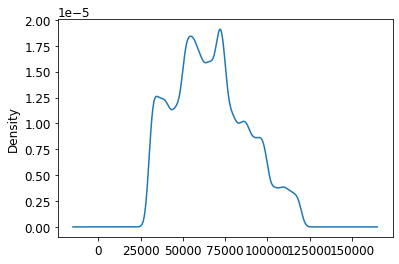

In [19]:
print('INCOME:')
joined.income.plot.kde()

AGE:


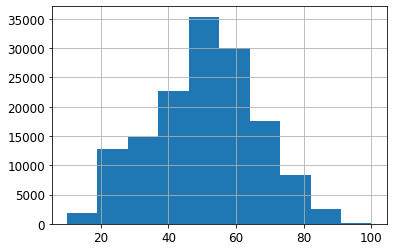

In [20]:
print('AGE:')
joined.age_by_decade.apply(lambda x: x*10).hist()

DAYS AS CUSTOMER:


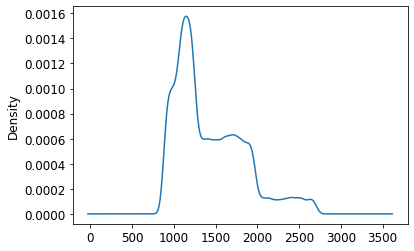

In [21]:
print('DAYS AS CUSTOMER:')
joined.days_as_customer.plot.kde()

GENDER


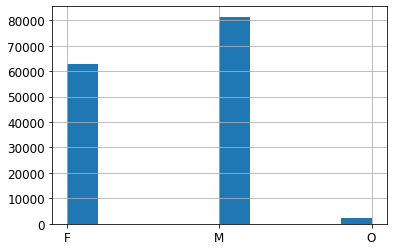

In [22]:
print('GENDER')
joined.gender.hist()

In [23]:
joined.dtypes

offer_person_id                object
offer_id                       object
event__offer completed          uint8
event__offer received           uint8
event__offer viewed             uint8
gender                       category
profile_person_id              object
income                          int64
age_by_decade                   int64
portfolio_id                   object
difficulty                      int64
duration                        int64
email                           uint8
mobile                          uint8
social                          uint8
web                             uint8
offer_type__bogo                uint8
offer_type__discount            uint8
offer_type__informational       uint8
person                         object
amount                        float64
days_as_customer                int64
became_member_dayofweek         int64
became_member_month             int64
became_member_year              int64
dtype: object

In [24]:
def scale_features(data):
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = list(data.select_dtypes('float'))
    keys_df = data[['offer_person_id', 'offer_id','profile_person_id', 'portfolio_id']] 
    features = data.drop(columns=[keys_df])
    features_log_minmax_transform = pd.DataFrame(data = features)
    features_log_minmax_transform[numerical] = scaler.fit_transform(data[numerical])
    return features_log_minmax_transform

features_log_minmax_transform = scale_features(joined)
display(features_log_minmax_transform.head(n = 5))

,event__offer completed,event__offer received,event__offer viewed,gender,income,age_by_decade,difficulty,duration,email,mobile,...,web,offer_type__bogo,offer_type__discount,offer_type__informational,person,amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
0,0,1,0,F,100000,7,5,7,1,1,...,1,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,0.050082,1325,1,5,2017
1,0,0,1,F,100000,7,5,7,1,1,...,1,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,0.050082,1325,1,5,2017
2,1,0,0,F,100000,7,5,7,1,1,...,1,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,0.050082,1325,1,5,2017
3,0,1,0,F,100000,7,0,3,1,1,...,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,0.050082,1325,1,5,2017
4,0,0,1,F,100000,7,0,3,1,1,...,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,0.050082,1325,1,5,2017


In [25]:
def clean_and_prep_features(features_log_minmax_transform, print_vif=True):
    """This takes the outputted scaled features from the 'scale_features' function,
    drops NaNs and unnecessary columns, and then separates X and Y vars.
    
    NOTE: The dropped variables were determined by running the VIF and retroactively updating this function
    However, I commented this out since RandomForest is the chosen model 
    and as such is robust to multicolinearity."""
    features_log_minmax_transform = features_log_minmax_transform.dropna()
    y=features_log_minmax_transform['event__offer completed']
    features = features_log_minmax_transform.drop(columns=['event__offer completed','person'
#                                                            'event__offer viewed'
    #                                                         'transaction_amount'])
                                                          ])
#     features.drop(columns=['days_as_customer','became_member_month','became_member_year','gender'])
    return features, y
        
def VIF(df):
    """This calculates the Variable Inflation Factor to help eliminate multicolinearity from
    the data.
    
    NOTE: This is useful for exploring and evaluating models, but isn't necessary for
    the eventual chosen model - RandomForest."""
    def calc_vif(X):
        vif = pd.DataFrame()
        vif["variables"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return(vif)

    vif = calc_vif(df.dropna())
    vif = vif[vif.VIF > 10]
    vif.VIF = vif.VIF.replace([np.inf, -np.inf], np.nan)
    vif = vif.dropna()
    # if print_vif:
    display(vif)
    print(f'Variables to drop with high VIF values: {vif.variables.tolist()}')


def split_and_resample(features, y):
    """
    Adapted from:
    https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
    
    This resamples the dataset to solve the class-imbalance issue at hand.
    
    SIDE NOTE: THe 'class imbalance problem' of
    classification models biases classification towards the majority class
    and results in misleading accuracy scores. 
    I.e. A model can always predict the majority class value and still be
    technically correct the majority of the time but fail to serve the 
    purpose of the model.
    """
    y_var_name = 'event__offer completed'
    # concatenate our training data back together
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
    X = pd.concat([X_train, y_train], axis=1)
    cols = list(X_train); cols.append(y_var_name)
    X.columns = cols
    X[y_var_name] = X[y_var_name].astype(int)
    # separate minority and majority classes
    majority = X[X[y_var_name] == 0.0]
    minority = X[X[y_var_name]== 1]
    # upsample minority
    upsampled = resample(minority,
                              replace=True, # sample with replacement
                              n_samples=len(majority), # match number in majority class
                              random_state=27) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([majority, upsampled])
    display(upsampled[y_var_name].value_counts())
    
    y_train = upsampled[y_var_name]
    X_train = upsampled.drop(y_var_name, axis=1)
    return X_train, X_test, y_train, y_test


features, y = clean_and_prep_features(scale_features(joined), print_vif=False)
exclusions = ['gender',
#               'event__offer received', 'event__offer viewed', 'person'
             ]
X_train, X_test, y_train, y_test = split_and_resample(features.drop(columns=exclusions), y)
VIF(X_train.dropna())

# Show the results of the split
print("\nTraining set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

1    90946
0    90946
Name: event__offer completed, dtype: int64

,variables,VIF
14,days_as_customer,2204.154981
16,became_member_month,149.815656
17,became_member_year,2391.385699


Variables to drop with high VIF values: ['days_as_customer', 'became_member_month', 'became_member_year']

Training set has 181892 samples.
Testing set has 29238 samples.


In [26]:
def grid_search(model, params, X, y, X_train, y_train, X_test, y_test):
    """Adapted from my Introduction to ML project"""
    scorer = make_scorer(f1_score)
    g_search = GridSearchCV(model, params,
                              cv=StratifiedKFold(n_splits=5, 
                                                 shuffle = True, 
                                                 random_state = 1001).split(
                                  X, y.values.ravel()), verbose=3, n_jobs=6)
    g_fit = g_search.fit(X, y.values)
    best_model = g_fit.best_estimator_
    predictions = (model.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_model.predict(X_test)
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))   
    
    return {
        'best_clf': best_model,
        'unoptimized_accuracy_score': accuracy_score(y_test, predictions),
        'unoptimized_beta_score': fbeta_score(y_test, predictions, beta = 0.5),
        'optimized_accuracy_score': accuracy_score(y_test, best_predictions),
        'optimized_beta_score': fbeta_score(y_test, best_predictions, beta = 0.5),
    }


In [27]:
def train_and_plot(model, X_train, y_train, X_test, y_test, show_plots=True):
    """
    This trains and plots resulting metrics for a given model and it's split datasets.
    
    DISCUSSION:
    F1 scores, precision, recall, and ROC AUC are used as metrics in addition 
    to accuracy scores particularly because accuracy scores are misleading
    for classification models with imbalanced classes.
    
    ADAPTED FROM:
    https://machinelearningmastery.com/
    roc-curves-and-precision-recall-curves-for-classification-in-python/
    """
    start = time()
    model.fit(X_train[X_train.notnull()], y_train[y_train.notnull()].values.ravel())
    model.predict(X_test)
    predictions_train = model.predict(X_train) 
    predictions_test = model.predict(X_test)

    ns_probs = [0 for _ in range(len(y_test))]
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    auc = roc_auc_score(y_test, probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    
    end = time() - start
    
    ptrain, rtrain, ftrain, _ = precision_recall_fscore_support(y_train, predictions_train,
                                                 average='macro')
    ptest, rtest, ftest, _ = precision_recall_fscore_support(y_test, predictions_test,
                                                 average='macro')
    creport = pd.DataFrame(classification_report(y_test, predictions_test, output_dict=True)).transpose()
    model_name = model.__class__.__name__
    results_df = pd.DataFrame([
    (model_name, 'model_score', model.score(X_test, y_test), end),
    (model_name, 'acc_train', accuracy_score(y_train, predictions_train), end),
    (model_name, 'acc_test', accuracy_score(y_test, predictions_test), end),
    (model_name, 'f_train', fbeta_score(y_train, predictions_train, beta=0.5), end),
    (model_name, 'f_test', fbeta_score(y_test, predictions_test, beta=0.5), end),
    (model_name, 'precision_train', ptrain, end),
    (model_name, 'precision_test', ptest, end),
    (model_name, 'recall_train', rtrain, end),
    (model_name, 'recall_test', rtest, end),
    (model_name, 'f1_train', ftrain, end),
    (model_name, 'f1_test', ftest, end),
    (model_name, 'No Skill: ROC AUC', ns_auc, end),
    (model_name, 'ROC AUC', auc, end),
    ], columns=['Model','Metric', 'Score', 'Training_time'])
    
    if show_plots:
        display(creport)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label=model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
    return results_df

In [28]:
%%time
"""Adapted from:
https://scikit-learn.org/
stable/auto_examples/classification/plot_classifier_comparison.html
"""

features, y = clean_and_prep_features(scale_features(joined), print_vif=False)
X_train, X_test, y_train, y_test = split_and_resample(
    features.drop(columns=['gender' #, 'event__offer received', 'event__offer viewed'
                          ]).dropna(), y)

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    xgb.XGBClassifier(),
    LogisticRegression(solver='lbfgs')
]

results_df = pd.DataFrame(columns=['Model','Metric', 'Score'])
for model in classifiers:
    start = time()
    print(f'\033[1m{model.__class__.__name__}\033[0m')
    results_df = pd.concat([results_df, train_and_plot(model, X_train, y_train, X_test, y_test, show_plots=False)])
    print(f"--- {time() - start} seconds ---")

pd.set_option('display.max_rows', 500)
results_df

1    90946
0    90946
Name: event__offer completed, dtype: int64

DecisionTreeClassifier
--- 0.5334799289703369 seconds ---
RandomForestClassifier
--- 1.230633020401001 seconds ---
AdaBoostClassifier
--- 12.02372407913208 seconds ---
GaussianNB
--- 0.49261999130249023 seconds ---
XGBClassifier
--- 4.446367025375366 seconds ---
LogisticRegression
--- 3.219623327255249 seconds ---
CPU times: user 1min 18s, sys: 4.01 s, total: 1min 22s
Wall time: 22.2 s


,Model,Metric,Score,Training_time
0,DecisionTreeClassifier,model_score,1.000000,0.381411
1,DecisionTreeClassifier,acc_train,1.000000,0.381411
2,DecisionTreeClassifier,acc_test,1.000000,0.381411
3,DecisionTreeClassifier,f_train,1.000000,0.381411
4,DecisionTreeClassifier,f_test,1.000000,0.381411
5,DecisionTreeClassifier,precision_train,1.000000,0.381411
6,DecisionTreeClassifier,precision_test,1.000000,0.381411
7,DecisionTreeClassifier,recall_train,1.000000,0.381411
8,DecisionTreeClassifier,recall_test,1.000000,0.381411
9,DecisionTreeClassifier,f1_train,1.000000,0.381411


In [29]:
results_df.sort_values(by='Score', ascending=False).query("Metric == 'ROC AUC'")

,Model,Metric,Score,Training_time
12,XGBClassifier,ROC AUC,1.000000,4.261737
12,DecisionTreeClassifier,ROC AUC,1.000000,0.381411
12,AdaBoostClassifier,ROC AUC,1.000000,11.789022
12,RandomForestClassifier,ROC AUC,0.996347,1.044428
12,GaussianNB,ROC AUC,0.950106,0.330882
12,LogisticRegression,ROC AUC,0.948187,3.090894


,precision,recall,f1-score,support
0,0.998330,0.996710,0.997520,22798.000000
1,0.988421,0.994099,0.991252,6440.000000
accuracy,0.996135,0.996135,0.996135,0.996135
macro avg,0.993376,0.995405,0.994386,29238.000000
weighted avg,0.996148,0.996135,0.996139,29238.000000


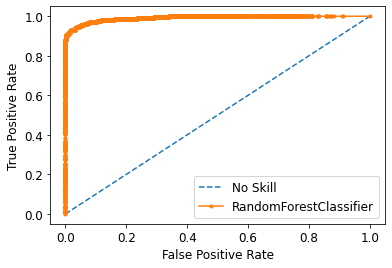

,Model,Metric,Score,Training_time
0,RandomForestClassifier,model_score,0.791709,0.968061
1,RandomForestClassifier,acc_train,0.995156,0.968061
2,RandomForestClassifier,acc_test,0.996135,0.968061
3,RandomForestClassifier,f_train,0.996028,0.968061
4,RandomForestClassifier,f_test,0.989551,0.968061
5,RandomForestClassifier,precision_train,0.995161,0.968061
6,RandomForestClassifier,precision_test,0.993376,0.968061
7,RandomForestClassifier,recall_train,0.995156,0.968061
8,RandomForestClassifier,recall_test,0.995405,0.968061
9,RandomForestClassifier,f1_train,0.995156,0.968061


In [30]:
train_and_plot(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               X_train, y_train, X_test, y_test)


In [31]:
%%time
rf_params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
features, y = clean_and_prep_features(scale_features(joined), print_vif=False)
exclusions = ['gender',
#               'event__offer received', 'event__offer viewed', 'person'
             ]
X_train, X_test, y_train, y_test = split_and_resample(features.drop(columns=exclusions), y)

grid_search_results = grid_search(RandomForestClassifier(),
                          rf_params, features.drop(columns=exclusions), y, 
                          X_train, y_train,
                          X_test, y_test)

1    90946
0    90946
Name: event__offer completed, dtype: int64

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Unoptimized model
------
Accuracy score on testing data: 1.0000
F-score on testing data: 1.0000

Optimized Model
------
Final accuracy score on the testing data: 0.9996
Final F-score on the testing data: 0.9997
CPU times: user 16.3 s, sys: 448 ms, total: 16.7 s
Wall time: 17min 35s


In [35]:
with open('grid_search_results.pkl', 'wb') as f:
    pickle.dump(grid_search_results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('grid_search_results.pkl', 'rb') as f:
    grid_search_results = pickle.load(f)

In [37]:
grid_search_results['best_clf']

RandomForestClassifier(max_depth=4, n_estimators=200)

In [38]:
features, y = clean_and_prep_features(scale_features(joined), print_vif=False)
exclusions = ['gender',
#               'event__offer received', 'event__offer viewed', 'person'
             ]
X_train, X_test, y_train, y_test = split_and_resample(features.drop(columns=exclusions), y)

rf = RandomForestClassifier(max_depth=4, n_estimators=200)
rf.fit(X_train, y_train)

1    90946
0    90946
Name: event__offer completed, dtype: int64

RandomForestClassifier(max_depth=4, n_estimators=200)

In [40]:
xt = X_test.copy()
xt['predicted'] = rf.predict(X_test)
xt = xt.merge(y_test, how='inner', left_index=True, right_index=True).rename(columns= {'event__offer completed':'actual'})
xt
print('Not matched:', len(xt[xt.predicted != xt.actual]))
print('Matched:', len(xt[xt.predicted == xt.actual]))

Not matched: 0
Matched: 29238


Text(0.5, 0, 'Permutation Importance')

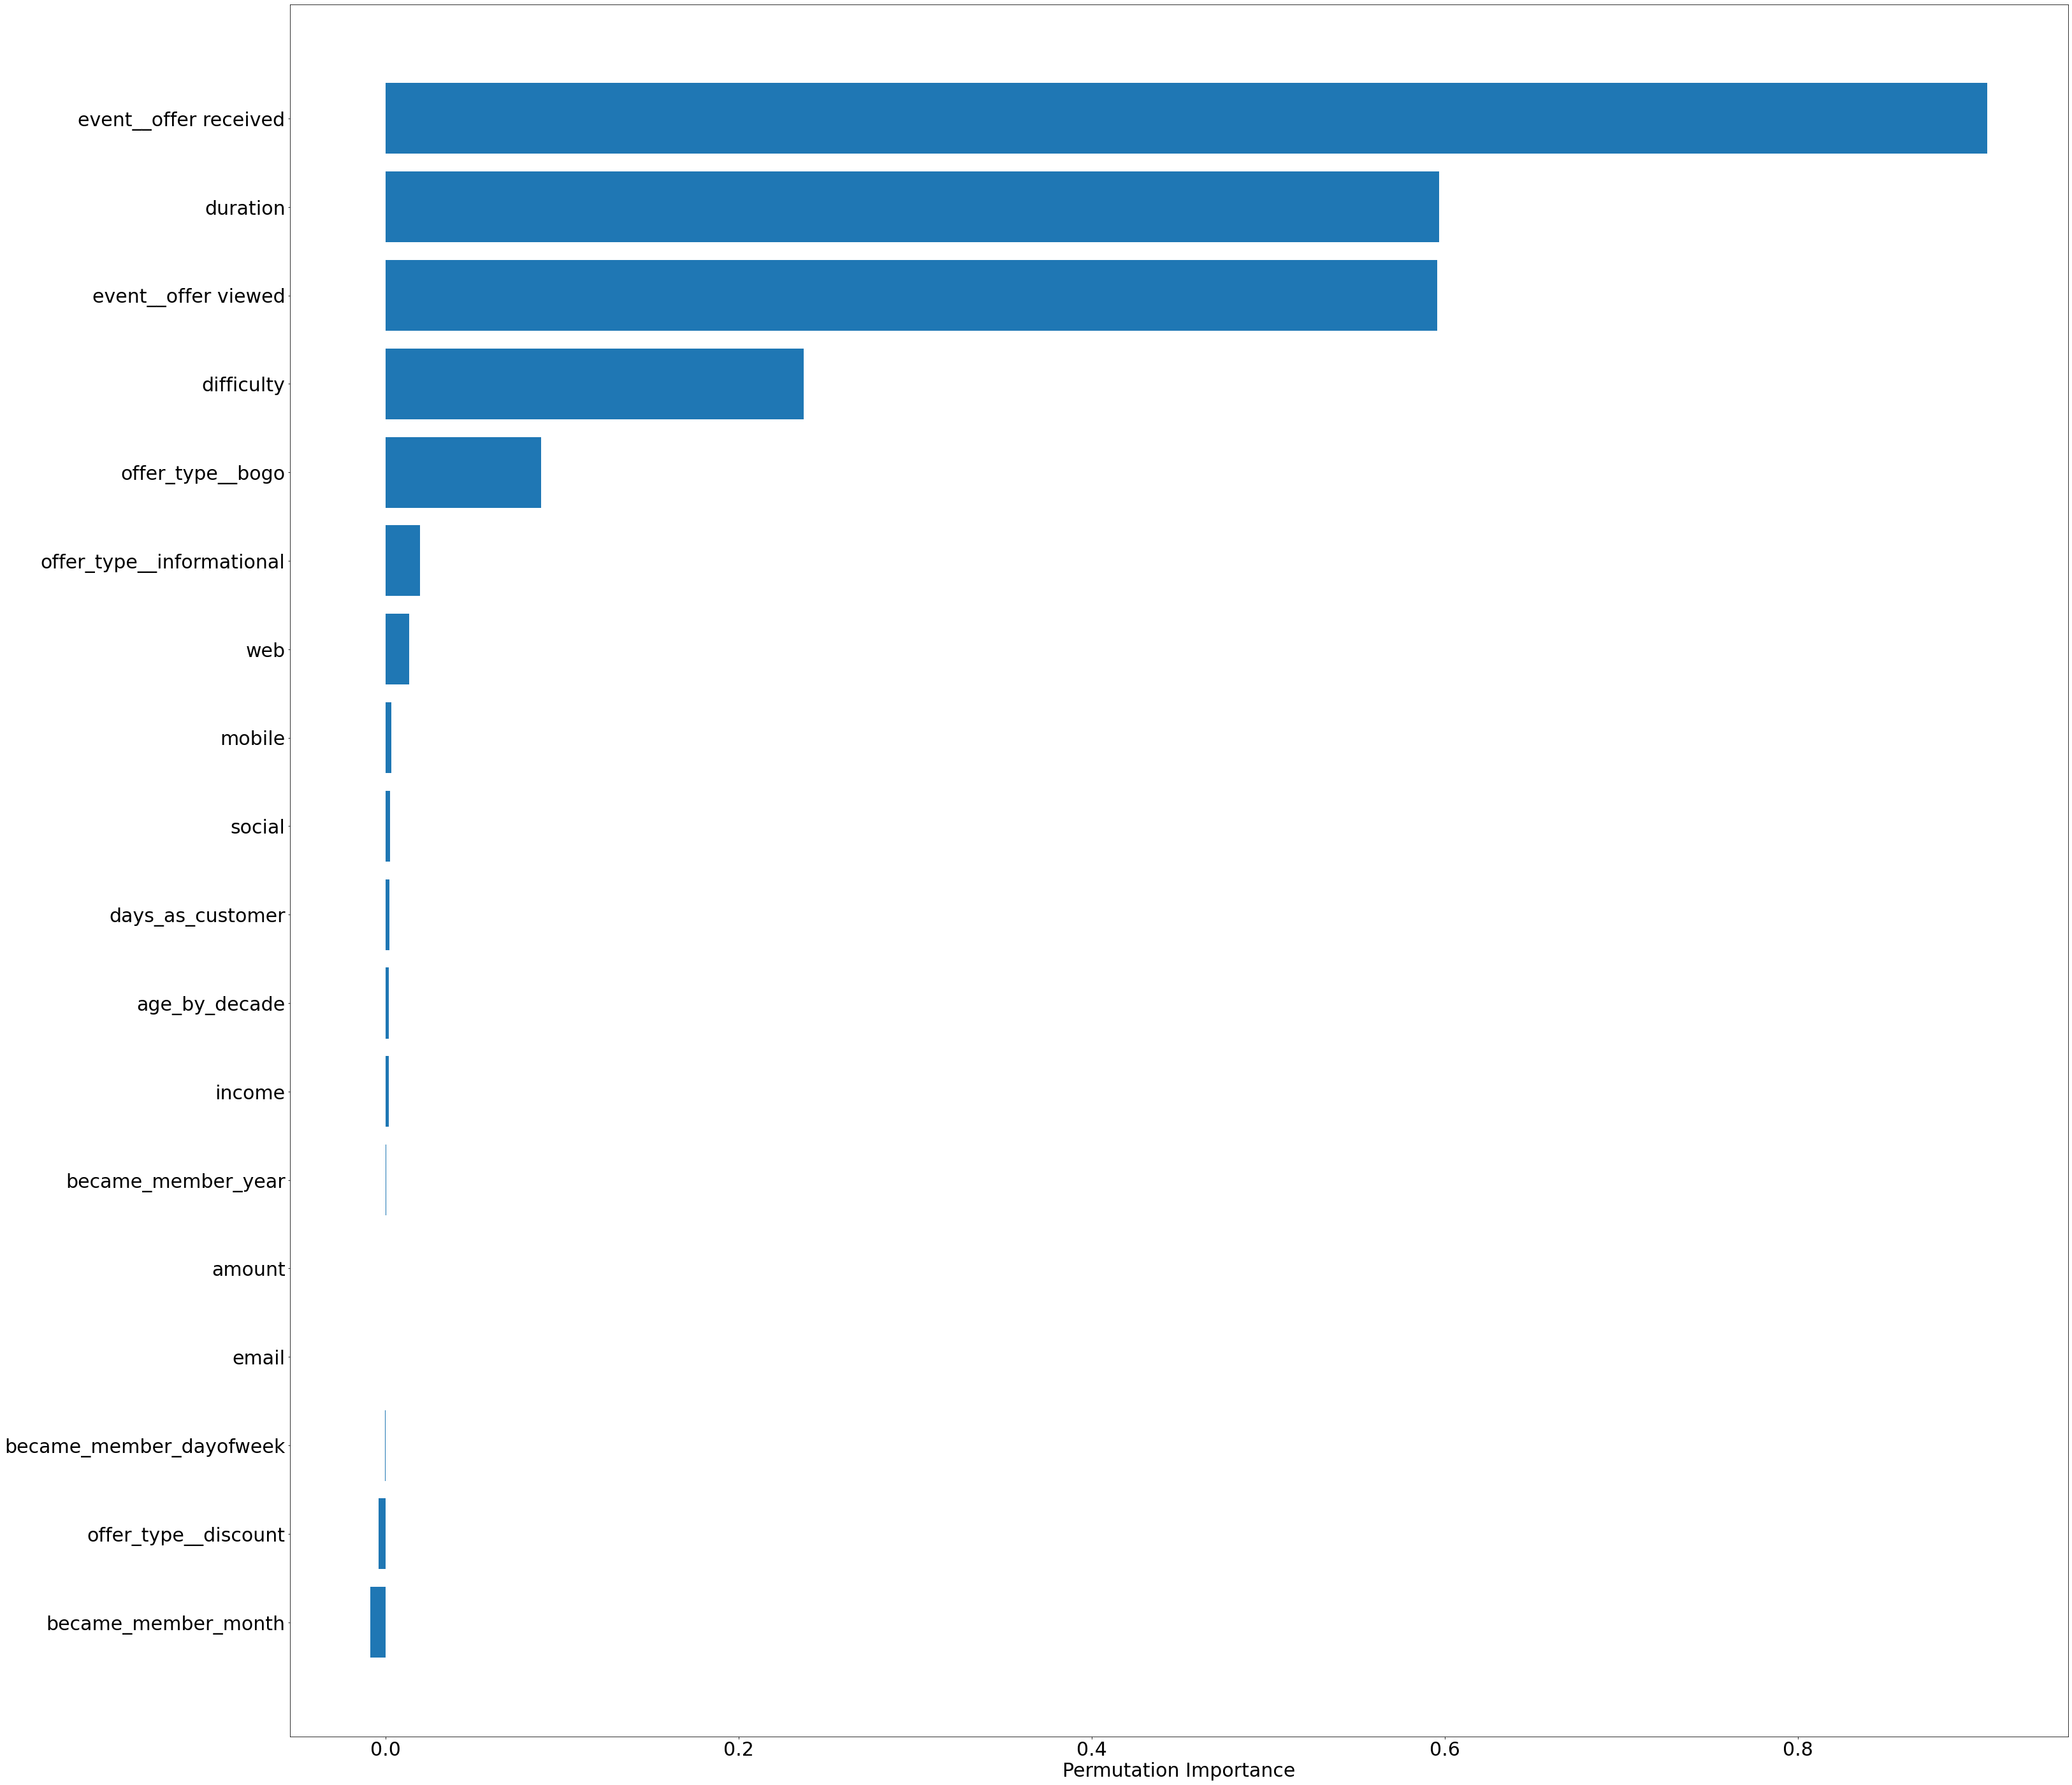

In [41]:
'''Adapted from:
https://mljar.com/blog/feature-importance-in-random-forest/
'''
# from rfpimp import permutation_importances
from sklearn.inspection import permutation_importance
r2 = lambda model, X_train, y_train : r2_score(y_train.values.ravel(), model.predict(X_train))
perm_importance = permutation_importance(model, X_train, y_train, r2)
sorted_idx = perm_importance.importances_mean.argsort()
plt.rc('font', size=30)   
plt.figure(figsize=(50, 50))
plt.barh(features.drop(columns=['gender']).columns[sorted_idx], 
         perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


# SUMMARY OF STEPS

## Issues:
- Multicolinearity - VIF scores
- Class Imbalance Issues - Resampling
- Datasets containing multiple entities (offers/transcripts)

## Cleaning and Feature engineering:
- Engineering new features for age, gender, channels, dateparts, etc..
- Removing columns

## Evaluation:
- Comparison of multiple classification algorithsm using multiple classification metrics, classification reports, plots, and output dataframes.
- Grid search on chosen algorithm

# DISCUSSION
The classification model would likely be of minimal value if deployed in an app - predicting that a given customer will fulfill a offer doesn't make it more likely to happen to or create additional value for the organization.

However, it may be useful for modeling real world customer lifecycles. It possible that this model could be used for marketing purposes. For example, if there are a number of important variables that can be manipulated by the organization or a group of people that can be targeted to increase customer conversion then it may be able to provide actual, measurable value.

One caveat here is that further causal inference needs to be exercised for which this model wouldn't necessarily be the best. A multiple regression model, A/B testing, and statistical inference techniques in general would be much better. Prediction and causality are two separate problem spaces.

In [43]:
with open('grid_search_results.pkl', 'rb') as f:
    grid_search_results = pickle.load(f)
with open('model.pkl', 'wb') as f:
    pickle.dump(grid_search_results['best_clf'], f, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
import json
"""Creating example json input file"""
d = json.loads(X_test.head(n=1).to_json())

for k,v in d.items():
    d[k] = list(v.values())[0]

open('example.json', 'w+').write(json.dumps(d))    

386